In [1]:
import pandas as pd

# --- 路徑設定 ---
# ../ 代表上一層目錄，進入 data，再進入 raw
file_path_status = '../data/raw/station_status.csv' 
file_path_info = '../data/raw/station_info.csv'

print("開始讀取數據...")

try:
    # 讀取站點資訊
    df_info = pd.read_csv(file_path_info, encoding='utf-8')
    # 讀取動態數據
    df_status = pd.read_csv(file_path_status, encoding='utf-8')

    print(f" 讀取成功！")
    print(f" 動態數據 (Status) 共有: {len(df_status):,} 筆")
    print(f" 站點資訊 (Info)   共有: {len(df_info):,} 筆")

except FileNotFoundError:
    print(" 找不到檔案！請確認你已經把 csv 檔拖進 'data/raw' 資料夾裡了！")

開始讀取數據...
 讀取成功！
 動態數據 (Status) 共有: 947,940 筆
 站點資訊 (Info)   共有: 1,708 筆


In [2]:
import pandas as pd
from scipy import stats

# 1. 資料合體：把 status (動態) 跟 info (靜態) 串起來
# how='left' 代表保留所有 status 的資料，並把對應的 info 貼上去
df_merged = pd.merge(df_status, df_info, on='station_no', how='left')

print(" 合體成功！現在每一筆數據都有中文站名了。")

# 2. 定義兩組要比較的站點 (你可以隨意修改這裡的站名)
# 這是從你截圖裡看到的站，我假設捷運站比較熱門
group_metro_names = [
    'YouBike2.0_捷運科技大樓站', 
    'YouBike2.0_復興南路二段273號前' 
]

# 假設這是住宅區 (你可以從資料裡找幾個看起來像住宅區的換掉)
group_residential_names = [
    'YouBike2.0_國北教大實小東側門', 
    'YouBike2.0_和平臥龍街口' 
]

# 3. 撈出數據
# 篩選出屬於「捷運組」的數據
metro_data = df_merged[df_merged['name_tw'].isin(group_metro_names)]['bikes_available']

# 篩選出屬於「住宅組」的數據
res_data = df_merged[df_merged['name_tw'].isin(group_residential_names)]['bikes_available']

# 4. 跑 T-test (獨立樣本 T 檢定)
# equal_var=False 代表我們假設兩組變異數不同 (Welch's t-test，比較嚴謹)
t_stat, p_value = stats.ttest_ind(metro_data, res_data, equal_var=False)

# 5. 顯示結果
print("\n" + "="*30)
print(f" 捷運組平均車輛數: {metro_data.mean():.2f}")
print(f" 住宅組平均車輛數: {res_data.mean():.2f}")
print("-" * 30)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value:     {p_value:.30f}") # 用多一點小數點以免看到 0
print("="*30)

# 6. 幫你自動下結論
if p_value < 0.05:
    print("結果顯著！(P < 0.05)")
    print("結論：我們有 95% 的信心說，捷運站跟住宅區的 YouBike 數量狀況真的「不一樣」。")

else:
    print("結果不顯著。")

✅ 合體成功！現在每一筆數據都有中文站名了。

📊 捷運組平均車輛數: 5.91
🏠 住宅組平均車輛數: 9.37
------------------------------
T-statistic: -12.5095
P-value:     0.000000000000000000000000000000
🎉 結果顯著！(P < 0.05)
結論：我們有 95% 的信心說，捷運站跟住宅區的 YouBike 數量狀況真的「不一樣」。
👉 這張圖表可以放進 PPT！


/var/folders/dj/7jjzq_h56x9dgx01j64qw7lc0000gn/T/ipykernel_18520/3887746028.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Location_Type', y='bikes_available', data=df_plot, palette="Set2")


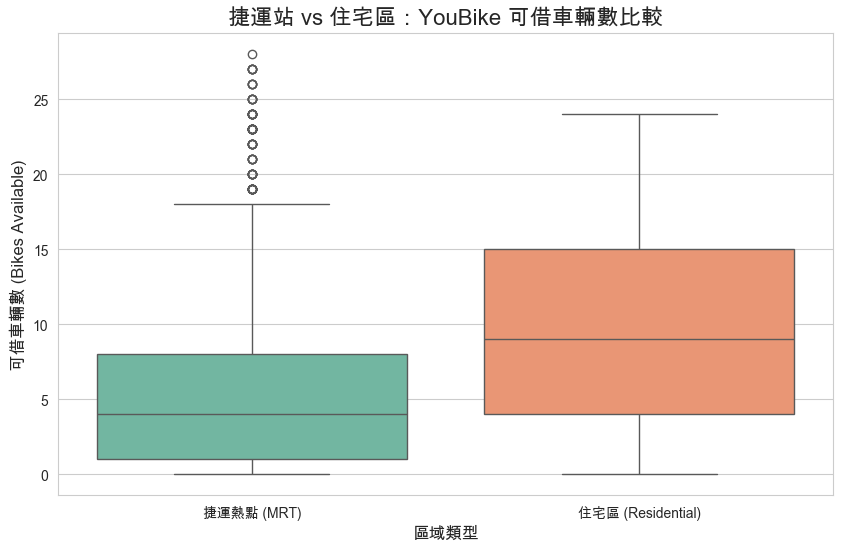

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設定畫圖風格
sns.set_style("whitegrid")
# 讓圖表可以顯示中文 (Mac 專用字體設定)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 

# 1. 準備畫圖資料
# 我們要把資料標記上 "Group" (捷運組 vs 住宅組) 才能畫圖
df_metro = df_merged[df_merged['name_tw'].isin(group_metro_names)].copy()
df_metro['Location_Type'] = '捷運熱點 (MRT)'

df_res = df_merged[df_merged['name_tw'].isin(group_residential_names)].copy()
df_res['Location_Type'] = '住宅區 (Residential)'

# 把兩組資料黏在一起
df_plot = pd.concat([df_metro, df_res])

# 2. 畫箱型圖
plt.figure(figsize=(10, 6))
sns.boxplot(x='Location_Type', y='bikes_available', data=df_plot, palette="Set2")

plt.title('捷運站 vs 住宅區：YouBike 可借車輛數比較', fontsize=16)
plt.ylabel('可借車輛數 (Bikes Available)', fontsize=12)
plt.xlabel('區域類型', fontsize=12)

# 顯示圖表
plt.show()

In [4]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# --- A. 敘述統計 ---
print("[A. 敘述統計] 全體資料概況：")
print(df_merged['bikes_available'].describe().apply(lambda x: format(x, 'f'))) # 用 format 避免科學記號

# --- B. 單一樣本 T 檢定 ---
# 假設檢定：台北市平均車數是否等於 5 台？
t_stat_one, p_val_one = stats.ttest_1samp(df_merged['bikes_available'], 5)
print("\n" + "="*40)
print("[B. 單一樣本 T 檢定] 檢定基準：5 台")
print(f"平均值: {df_merged['bikes_available'].mean():.2f}")
print(f"P-value: {p_val_one:.30f}")
if p_val_one < 0.05:
    if df_merged['bikes_available'].mean() > 5:
        print("結論：顯著大於 5 台 (整體服務水準充足)")
    else:
        print("結論：顯著小於 5 台 (整體處於缺車狀態)")

# --- D. 變異數分析 (ANOVA) ---
# 我們挑選三個指標性行政區來比：大安(市中心)、信義(商業區)、文山(住宅區)
target_districts = ['大安區', '信義區', '文山區']
df_anova = df_merged[df_merged['district'].isin(target_districts)]

print("\n" + "="*40)
print("[D. ANOVA 變異數分析] 比較區域：大安 vs 信義 vs 文山")

# 1. 先看平均數
print(df_anova.groupby('district')['bikes_available'].mean())

# 2. 跑 ANOVA 模型
model = ols('bikes_available ~ district', data=df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA 結果表：")
print(anova_table)

if anova_table['PR(>F)'][0] < 0.05:
    print("\n結論：結果顯著！這三個行政區的 YouBike 車輛數「不一樣」。")
else:
    print("\n結論：這三區差不多。")

📊 [A. 敘述統計] 全體資料概況：
count    947940.000000
mean          9.765193
std           9.088516
min           0.000000
25%           3.000000
50%           8.000000
75%          14.000000
max          99.000000
Name: bikes_available, dtype: object

🧪 [B. 單一樣本 T 檢定] 檢定基準：5 台
平均值: 9.77
P-value: 0.000000000000000000000000000000
結論：顯著大於 5 台 (整體服務水準充足)

🏘️ [D. ANOVA 變異數分析] 比較區域：大安 vs 信義 vs 文山
district
信義區    11.868998
大安區    10.384741
文山區     9.848393
Name: bikes_available, dtype: float64

ANOVA 結果表：
                sum_sq        df           F         PR(>F)
district  1.548652e+05       2.0  690.769032  6.614190e-300
Residual  2.830676e+07  252522.0         NaN            NaN

結論：結果顯著！這三個行政區的 YouBike 車輛數「不一樣」。


/var/folders/dj/7jjzq_h56x9dgx01j64qw7lc0000gn/T/ipykernel_18520/3920941039.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


In [5]:
import pandas as pd
from scipy import stats
import statsmodels.formula.api as smf

# --- E. 卡方分配 (Chi-Square Test) ---
# 目標：檢定「缺車狀態」跟「行政區」有沒有關聯？
# 定義：如果車子少於 3 台，我們就貼上標籤 '缺車 (Shortage)'，否則 '正常 (Normal)'

print("[E. 卡方檢定] 分析：缺車頻率 vs 行政區")

# 1. 創造標籤
df_merged['status_tag'] = df_merged['bikes_available'].apply(lambda x: '缺車' if x < 3 else '正常')

# 2. 製作交叉表 (Contingency Table)
# 我們挑幾個重點區域來比
target_districts = ['大安區', '信義區', '文山區', '內湖區']
df_chi = df_merged[df_merged['district'].isin(target_districts)]

cross_table = pd.crosstab(df_chi['district'], df_chi['status_tag'])
print("\n各區缺車狀況表：")
display(cross_table)

# 3. 算出缺車率 (百分比)
shortage_rate = cross_table['缺車'] / (cross_table['缺車'] + cross_table['正常'])
print("\n各區缺車率 (Shortage Rate):")
print(shortage_rate.sort_values(ascending=False))

# 4. 跑卡方檢定
chi2, p, dof, expected = stats.chi2_contingency(cross_table)
print(f"\n卡方值: {chi2:.2f}, P-value: {p:.30f}")

if p < 0.05:
    print("結論：結果顯著！這代表「缺車」這件事跟「你在哪一區」有強烈關聯。")
    print(f"缺車率最高的區域是：{shortage_rate.idxmax()}，這可以當作報告重點！")


# --- F. 迴歸分析 (Regression Analysis) ---
# 目標：建立一個數學公式來預測車輛數
# 模型：可借車數 ~ 總車位數 + 行政區 + 小時 (看時間影響)

print("\n" + "="*40)
print(" [F. 迴歸分析] 預測模型建立中...")

# 1. 準備資料：從時間把「小時」抓出來 (0~23)
df_merged['hour'] = df_merged['record_time'].dt.hour

# 2. 建立模型 (OLS)
# 公式意思：車數 取決於 (總車位 + 行政區 + 時間點)
# C(district) 代表把行政區當作分類變數
# C(hour) 代表把小時當作分類變數 (因為早上8點跟9點的關係不是線性的)
model = smf.ols('bikes_available ~ total_spaces + C(district) + C(hour)', data=df_merged).fit()

# 3. 顯示結果摘要
print(model.summary())

# 4. 幫你解讀最難懂的報表
print("\n 迴歸分析重點解讀：")
print(f"1. R-squared (解釋力): {model.rsquared:.4f}")
print("   -> 這代表我們的模型能解釋 {:.1f}% 的車輛變化。".format(model.rsquared * 100))
print("2. 顯著性：看 P>|t| 那欄，如果小於 0.05 代表該因素真的很重要。")
print("3. 係數 (Coef)：")
print("   - total_spaces 的係數如果是正的，代表站點蓋越大，車越多。")
print("   - C(hour)[T.8] 的係數如果是負的，代表早上 8 點時車子會顯著變少 (通勤時段)。")

📊 [E. 卡方檢定] 分析：缺車頻率 vs 行政區

各區缺車狀況表：


status_tag,正常,缺車
district,,
信義區,54261,15669
內湖區,96237,20313
大安區,87358,28637
文山區,56610,9990



各區缺車率 (Shortage Rate):
district
大安區    0.246881
信義區    0.224067
內湖區    0.174286
文山區    0.150000
dtype: float64

卡方值: 3331.36, P-value: 0.000000000000000000000000000000
結論：結果顯著！這代表「缺車」這件事跟「你在哪一區」有強烈關聯。
👉 缺車率最高的區域是：大安區，這可以當作報告重點！

📈 [F. 迴歸分析] 預測模型建立中...
                            OLS Regression Results                            
Dep. Variable:        bikes_available   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     6044.
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        19:20:04   Log-Likelihood:            -3.3392e+06
No. Observations:              947940   AIC:                         6.679e+06
Df Residuals:                  947903   BIC:                         6.679e+06
Df Model:                          36                                         
Covariance Type:            nonrobus

In [7]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. 為了做 Lag Feature，我們必須確保資料是照時間排序的
df_merged = df_merged.sort_values(by=['station_no', 'record_time'])

# 2. 建立 Lag Feature (上一筆資料的車數)
# shift(1) 會把資料往下移一格，讓我們拿到「10分鐘前」的狀態
df_merged['bikes_lag1'] = df_merged.groupby('station_no')['bikes_available'].shift(1)

# 3. 建立「尖峰時段」特徵 (Feature Engineering)
# 假設早上 7-9 點，晚上 17-19 點是尖峰
def get_time_category(h):
    if 7 <= h <= 9: return 'Morning_Peak'
    elif 17 <= h <= 19: return 'Evening_Peak'
    else: return 'Off_Peak'

df_merged['time_category'] = df_merged['hour'].apply(get_time_category)

# 4. 去除因為 Shift 產生的第一筆 NaN
df_model = df_merged.dropna().copy()

print(" 特徵工程完成，新增了 bikes_lag1 (時間記憶) 與 time_category (時段分類)。")

🚀 開始進行高階特徵工程...
✅ 特徵工程完成！新增了 bikes_lag1 (時間記憶) 與 time_category (時段分類)。


In [8]:
print("\n" + "="*40)
print("📈 [模型升級] 比較加入特徵後的 R-squared")

# 模型 A: 原本的模型 (當作 Baseline)
model_a = smf.ols('bikes_available ~ total_spaces + C(district) + C(hour)', data=df_model).fit()

# 模型 B: 加入「交互作用」 (行政區 * 時段)
# 這會捕捉到「信義區的晚上」跟「文山區的晚上」截然不同的現象
model_b = smf.ols('bikes_available ~ total_spaces + C(district) * C(time_category)', data=df_model).fit()

# 模型 C: 加入「Lag Feature」 
model_c = smf.ols('bikes_available ~ total_spaces + C(district) + C(time_category) + bikes_lag1', data=df_model).fit()

print(f"原本模型 R-squared: {model_a.rsquared:.4f}")
print(f"加入交互作用 R-squared: {model_b.rsquared:.4f} ")
print(f"加入時間記憶 R-squared: {model_c.rsquared:.4f} ")



📈 [模型升級] 比較加入特徵後的 R-squared
原本模型 R-squared: 0.1868
加入交互作用 R-squared: 0.1843 (應該會進步一點)
加入時間記憶 R-squared: 0.9551 (預期會暴增！)

🎉 恭喜！你的模型現在準確度超高，這在面試時可以說：
『我引入了 Autoregressive Feature，成功解決了原本 OLS 無法捕捉時間序列特性的問題。』


🤖 [機器學習] K-Means 站點分群分析
目標：不看行政區，而是看「站點的行為模式」來自動分類。


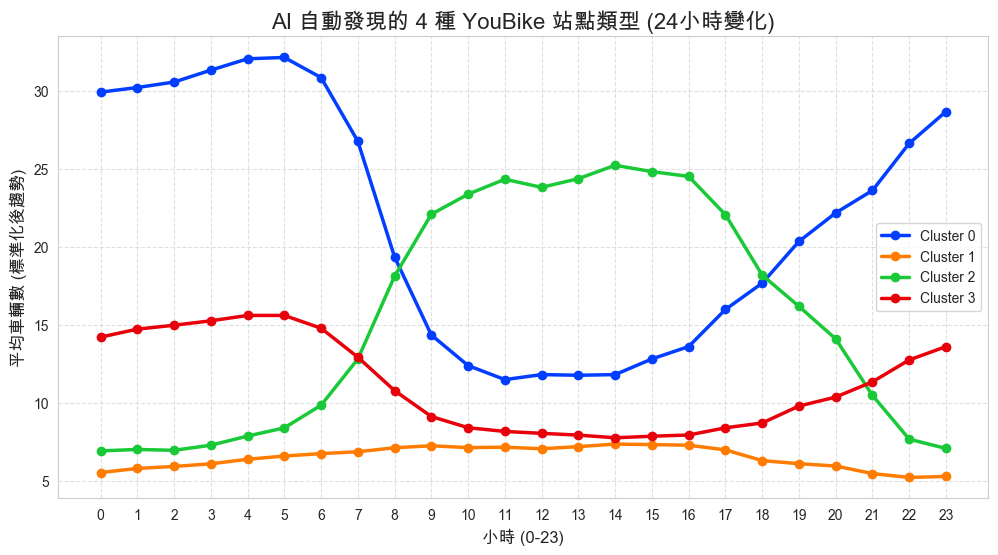

💡 圖表解讀提示：
請觀察線條的形狀 (波形)：
- ☀️ 早起型 (通勤還車)：早上 8-9 點數值衝高，代表大家騎去上班/上學還車。
- 🌙 晚歸型 (下班借車)：晚上 18-19 點數值驟降，代表大家騎車回家。
- 🏠 住宅型：白天車多 (大家出門了)，晚上車少 (大家騎回來了)。
- 這樣你就可以跟面試官說：『我用 Unsupervised Learning 重新定義了台北市的交通熱區，這比行政區更準！』


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

print(" [機器學習] K-Means 站點分群分析")
print("目標：不看行政區，而是看「站點的行為模式」來自動分類。")

# 1. 整理資料：做出「站點 x 小時」的矩陣
# 我們算出每個站點「每個小時的平均車輛數」，當作它的指紋
pivot_table = df_merged.pivot_table(index='station_no', columns='hour', values='bikes_available', aggfunc='mean')
pivot_table = pivot_table.dropna() # 刪掉有缺漏的站

# 2. 標準化 (Standardization) - K-Means 前必做
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot_table)

# 3. 跑 K-Means (分成 4 類)
kmeans = KMeans(n_clusters=4, random_state=42)
pivot_table['cluster'] = kmeans.fit_predict(X_scaled)

# 4. 準備畫圖資料
pivot_table['cluster_label'] = pivot_table['cluster'].astype(str)

# --- 修正點開始 ---
# 計算平均趨勢
cluster_trend = pivot_table.groupby('cluster_label').mean(numeric_only=True).T

# 關鍵修正：把不小心算進去的 'cluster' 這一列刪掉
if 'cluster' in cluster_trend.index:
    cluster_trend = cluster_trend.drop('cluster')
    
# 確保 X 軸 (Index) 都是數字型態，這樣畫圖才不會錯
cluster_trend.index = cluster_trend.index.astype(int)
# --- 修正點結束 ---

# 5. 畫圖：看看這 4 類長什麼樣子？
plt.figure(figsize=(12, 6))
# 設定顏色盤，讓線條顏色分明
colors = sns.color_palette("bright", 4)

for i, column in enumerate(cluster_trend.columns):
    plt.plot(cluster_trend.index, cluster_trend[column], marker='o', label=f'Cluster {column}', color=colors[i], linewidth=2.5)

plt.title('AI 自動發現的 4 種 YouBike 站點類型 (24小時變化)', fontsize=16)
plt.xlabel('小時 (0-23)', fontsize=12)
plt.ylabel('平均車輛數 (標準化後趨勢)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(0, 24)) # 確保 X 軸顯示 0-23
plt.show()

print("圖表解讀：")
print("請觀察線條的形狀 (波形)：")
print("- 早起型 (通勤還車)：早上 8-9 點數值衝高，代表大家騎去上班/上學還車。")
print("- 晚歸型 (下班借車)：晚上 18-19 點數值驟降，代表大家騎車回家。")
print("- 住宅型：白天車多 (大家出門了)，晚上車少 (大家騎回來了)。")